In [331]:
import pyblp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import copy 

pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.__version__

'0.12.0'

In [346]:
dataset= pd.read_csv('Yr18_PSet_BLP_data_no_header.txt', delimiter= '\t',
                     header=None, names= ['prices', 'quantity', 'weight', 'power', 'ac', 'firm_ids'])

In [347]:
dataset['market_ids']=1

In [348]:
dataset[['prices', 'quantity', 'weight', 'power', 'ac']].describe()

,prices,quantity,weight,power,ac
count,131.000000,131.000000,131.000000,131.000000,131.000000
mean,18349.091603,66377.312977,2923.465649,133.587786,0.458015
std,12342.785926,74854.734184,564.955578,45.874556,0.500147
min,4435.000000,1037.000000,1620.000000,55.000000,0.000000
25%,10412.500000,14488.500000,2526.500000,100.000000,0.000000
50%,13800.000000,39602.000000,2839.000000,130.000000,0.000000
75%,23400.000000,94776.000000,3329.000000,160.000000,1.000000
max,73800.000000,417179.000000,4283.000000,278.000000,1.000000


In [349]:
#Data Pre-processing: change scale of variables to [0,1]:
dataset['prices']= dataset['prices']/10000
dataset['weight']= dataset['weight']/1000
dataset['power']= dataset['power']/100

In [361]:
M= 100000000 # Market size: 100 million
dataset['shares']= dataset['quantity']/M
dataset_gh= copy.deepcopy(dataset)

### Question 5: Logit and logit with supply side

In [359]:
#  BLP type instruments
demand_instruments = pyblp.build_blp_instruments(pyblp.Formulation('1 + weight + power + ac'), dataset)
for i in range(demand_instruments[0].size):
    dataset[f'demand_instruments{i}']= demand_instruments[:,i]
#     dataset[f'supply_instruments{i}']= demand_instruments[:,i]

# data2= dataset.copy()
# data2['market_ids']=2
# dataset= dataset.append(data2, ignore_index=True)
# dataset['market_ids']

In [362]:
# GH type instruments
cols = [c for c in dataset_gh.columns if c.lower()[:4] != 'dema']
dataset_gh= dataset_gh[cols]
gh_instruments = pyblp.build_differentiation_instruments(pyblp.Formulation('0+ weight + power + ac'), dataset)
for i in range(gh_instruments[0].size):
    dataset_gh[f'demand_instruments{i}']= gh_instruments[:,i]
blp_instruments = pyblp.build_blp_instruments(pyblp.Formulation(' 1'), dataset)

dataset_gh[f'demand_instruments{i+1}']= blp_instruments[:,0]
dataset_gh[f'demand_instruments{i+2}']= blp_instruments[:,1]

dataset_gh.head()

,prices,quantity,weight,power,ac,firm_ids,market_ids,shares,demand_instruments0,demand_instruments1,demand_instruments2,demand_instruments3,demand_instruments4,demand_instruments5,demand_instruments6,demand_instruments7
0,0.6488,90808,2.020,0.78,0,1,1,0.000908,4.0,4.0,4.0,59.0,79.0,66.0,8.0,122.0
1,0.8748,228211,2.390,1.02,0,1,1,0.002282,5.0,5.0,4.0,82.0,102.0,66.0,8.0,122.0
2,1.1588,284595,2.690,1.15,0,1,1,0.002846,7.0,5.0,4.0,99.0,105.0,66.0,8.0,122.0
3,1.2268,78521,2.500,1.03,0,1,1,0.000785,5.0,5.0,4.0,88.0,102.0,66.0,8.0,122.0
4,1.4898,14257,2.599,1.30,0,1,1,0.000143,5.0,6.0,4.0,93.0,107.0,66.0,8.0,122.0


In [154]:
logit_formulation = pyblp.Formulation('prices+ weight + power + ac ' )
logit_formulation

1 + prices + weight + power + ac

In [155]:
pyblp.options.collinear_atol= 0
pyblp.options.collinear_rtol= 0 # only one market, need to disable this
problem = pyblp.Problem(logit_formulation, dataset)
problem

Dimensions:
 T    N    F    K1    MD 
---  ---  ---  ----  ----
 1   131  20    5     12 

Formulations:
     Column Indices:         0     1       2       3     4 
--------------------------  ---  ------  ------  -----  ---
X1: Linear Characteristics   1   prices  weight  power  ac 

In [156]:
logit_demandonly= problem.solve()
logit_demandonly

Problem Results Summary:
GMM   Objective  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Shares   Condition Number  Condition Number 
----  ---------  -------  ----------------  -----------------
 2    +5.8E-02      0         +1.9E+21          +1.4E+03     

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         2     

Beta Estimates (Robust SEs in Parentheses):
    1         prices      weight      power         ac    
----------  ----------  ----------  ----------  ----------
 -9.5E+00    -1.2E+00    +1.0E+00    +7.0E-01    -1.8E-01 
(+7.7E-01)  (+4.2E-01)  (+3.4E-01)  (+8.4E-01)  (+3.9E-01)

In [164]:
logit_supply_formulation = (pyblp.Formulation('prices+ weight + power + ac ' ),
                            None,
                            pyblp.Formulation('weight + power + ac ' ))
logit_supply_formulation
problem = pyblp.Problem(logit_supply_formulation, dataset)
problem


Dimensions:
 T    N    F    K1    K3    MD    MS 
---  ---  ---  ----  ----  ----  ----
 1   131  20    5     4     12    4  

Formulations:
        Column Indices:           0     1       2       3     4 
-------------------------------  ---  ------  ------  -----  ---
  X1: Linear Characteristics      1   prices  weight  power  ac 
X3: Linear Cost Characteristics   1   weight  power    ac       

In [168]:
logit_supply= problem.solve(
    beta = [None, -1, None, None, None] )
logit_supply

Problem Results Summary:
GMM   Objective  Gradient            Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Hessian   Shares   Condition Number  Condition Number 
----  ---------  --------  --------  -------  ----------------  -----------------
 2    +3.2E-01   +4.8E-09  +2.0E-01     0         +2.1E+19          +1.2E+04     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective 
   Time      Converged   Iterations   Evaluations
-----------  ---------  ------------  -----------
 00:00:01       Yes          2             8     

Beta Estimates (Robust SEs in Parentheses):
    1         prices      weight      power         ac    
----------  ----------  ----------  ----------  ----------
 -1.0E+01    -1.1E+00    +1.4E+00    +2.3E-01    -2.6E-01 
(+8.0E-01)  (+3.7E-01)  (+3.2E-01)  (+7.1E-01)  (+3.5E-01)

Gamma Estimates (Robust SEs in Parentheses):
    1         weight      power         ac    
----------  ----------  ----------  ----------
 -

In [74]:
logit_supply.compute_markups()
logit_supply.compute_costs()
logit_supply.compute_elasticities()[0:5,0:5]


array([[-4.75517560e-01,  1.46452106e-03,  2.41927938e-03,
         7.06658945e-04,  1.55813969e-04],
       [ 4.32200459e-04, -6.40275384e-01,  2.41927938e-03,
         7.06658945e-04,  1.55813969e-04],
       [ 4.32200459e-04,  1.46452106e-03, -8.47658684e-01,
         7.06658945e-04,  1.55813969e-04],
       [ 4.32200459e-04,  1.46452106e-03,  2.41927938e-03,
        -8.99255065e-01,  1.55813969e-04],
       [ 4.32200459e-04,  1.46452106e-03,  2.41927938e-03,
         7.06658945e-04, -1.09273869e+00]])

### Question 6: Other alternatives:

* Nested logit model: it will help a little, but largely depends on the
selection of nests.

* pure characteristics model: it will help because it tries to meliorate
the effect of iid error term, but it is hard to estimate in this setting.

* multinomial probit: it also suffers from iid error problem (unless we
allow for correlations which is also hard to implement in this setting.)


### Question 7: BLP with observed heterogeneity

BLP: $u_{ij}=x_{j}\beta -\alpha _{i}p_{j}+\xi _{j}+\varepsilon _{ij}$
where $\alpha _{i}=\frac{1}{y_{i}}.$ Then $\delta _{j}=x_{j}\beta +\xi _{j}.$

The estimation will involve a Berry's inversion in the outer loop.What
we do here is to (given the distribution parameters of lognormal) calculate:

$$
s_{j}=\int \frac{e^{\delta _{j}-\frac{p_{j}}{y_{i}}}f\left( y_{i}\right)
dy_{i}}{1+\sum_{l}e^{\delta _{l}-\frac{p_{l}}{y_{i}}}f\left( y_{i}\right)
dy_{i}}
$$

repeat using contraction mapping: (until convergence, we set $\left\vert 
\hat{\delta}_{j+1}-\hat{\delta}_{j}\right\vert \leq 10^{-6}$, dropping 1
digit with 100 loops, start with logit value).%
* step 1:
$$
\hat{s}_{j}=\int_{y_{i}}\frac{\exp (\hat{\delta}_{j}-%
\frac{p_{j}}{y_{i}})dF\left( y_{i}\right) }{1+\sum_{k}\exp (\hat{\delta}_{j}-%
\frac{p_{k}}{y_{i}})dF\left( y_{i}\right) }=\frac{1}{N}\sum_{r=1}^{N}\frac{%
\exp (\hat{\delta}_{j}-\frac{p_{j}}{y_{r}})}{1+\sum_{k}\exp (\hat{\delta}%
_{k}-\frac{p_{k}}{y_{r}})}
$$
* step 2:
$$
\exp \left( \hat{\delta}_{j+1}\right) =\exp \left( 
\hat{\delta}_{j}\right) \frac{s_{obs}}{\hat{s}_{j}}
$$

where $\left\{ y_{r}\right\} _{r=1}^{N}$ is directly drawn from the
lognormal distribution given the distribution parameter $(\mu ,\sigma ).$

And then use GMM model to estimate $\beta $ and $\mu ,\sigma .$

Given $\alpha _{i}=\alpha _{1}+\frac{\alpha _{2}}{y_{i}}.$ $\delta
_{j}=x_{j}\beta -\alpha _{1}p_{j}+\xi _{j}.$Now the inversion becomes:%
$$
\ln (s_{j})-\ln \left( s_{0}\right) =\int_{y_{i}}(\delta _{j}-(\alpha _{1}+%
\frac{\alpha _{2}}{y_{i}}p_{j})dF\left( y_{i}\right) 
$$

Now we have another parameter $\alpha _{1}$ and $\alpha _{2}$ here to
estimate as a nonlinear parameter. It is hard to estimate without
instruments because the distribution of lognormal $\mu $ and $\alpha _{2}$
are compounding effects. It is not possible to seperately identify all of
them three. Given our limited sample data, it is not likely that $\alpha _{1}
$ can be identified too.

In [135]:
# Add agent data from lognormal draw (35000, 45000)
integration = pyblp.Integration('halton', size=100, specification_options={'seed': 0})
integration
agent_data_array= pyblp.build_integration(integration, 1)
agent_data_array.nodes
agent_data= pd.DataFrame.from_records(agent_data_array.weights, index=range(100), columns=['weights'])
m= 35000
v= 45000

agent_data['income']= np.exp(np.sqrt(np.log(v**2/m**2+1))*agent_data_array.nodes
                    + np.log(m**2/np.sqrt(v**2+ m**2)) )
agent_data['market_ids']=1
agent_data['nodes']= agent_data_array.nodes     
agent_data

,weights,income,market_ids,nodes
0,0.01,23186.676823,1,0.077028
1,0.01,3386.279832,1,-1.870613
2,0.01,46181.766727,1,0.774557
3,0.01,12107.453827,1,-0.580765
4,0.01,31923.699500,1,0.400754
...,...,...,...,...
95,0.01,18801.606799,1,-0.135200
96,0.01,21957.307868,1,0.021876
97,0.01,2053.441637,1,-2.377015
98,0.01,42996.735958,1,0.702213


In [209]:
product_formulations = (
   pyblp.Formulation('1 + prices + weight + power + ac'),
   pyblp.Formulation('0 + prices + power'),
   None
)
product_formulations

(1 + prices + weight + power + ac, prices + power, None)

In [248]:
agent_formulation = pyblp.Formulation('0 + I(1/income)+ income')
agent_formulation

I(1 / income) + income

In [364]:
problem = pyblp.Problem(product_formulations, dataset, agent_formulation, agent_data, costs_type='linear')
problem_gh = pyblp.Problem(product_formulations, dataset_gh, agent_formulation, agent_data, costs_type='linear')

In [ ]:
#optimization = pyblp.Optimization('l-bfgs-b', {'gtol': 1e-3})

initial_sigma = np.diag([0,0])
initial_pi = np.diag([1e4, 0])
initial_beta = logit_demandonly.to_dict(['beta'])['beta']
blp_results = problem.solve(
    initial_sigma,
    initial_pi
)
print(blp_results)

In [371]:
# Or we can try GH instruments:
initial_sigma = np.diag([0,0])
initial_pi = np.diag([-1e5, 0])
initial_beta = logit_demandonly.to_dict(['beta'])['beta']
blp_results_gh = problem_gh.solve(
    initial_sigma,
    initial_pi
)
print(blp_results_gh)

Problem Results Summary:
GMM   Objective  Gradient            Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Hessian   Shares   Condition Number  Condition Number 
----  ---------  --------  --------  -------  ----------------  -----------------
 2    +1.2E-06   +1.3E-12  -4.3E-14     0         +1.2E+20          +1.9E+13     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:00:00       Yes          1             7           20           65     

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:   prices    power    |   Pi:    1*1/income   income 
------  --------  --------  |  ------  ----------  --------
prices  +0.0E+00            |  prices   -1.0E+05   +0.0E+00
                            |          (+1.1E+05)          
                 

In [324]:
# Multi-start
np.random.seed= 211
initial_guess= np.append(np.random.rand(10), -np.random.rand(10))*35000
new_dict = {}
initial_sigma = np.diag([0,0])
i=0
for pi in initial_guess:
    initial_pi= np.diag([pi, 0])
    blp_multistart_results = problem.solve(
        initial_sigma,
        initial_pi,
        W= blp_results.W,
        method='1s', # use the same weighting matrix to compare
    )
    i= i+1
    new_dict[i]= blp_multistart_results


In [372]:
# Multi-start
np.random.seed= 211
initial_guess= np.append(np.random.rand(10), -np.random.rand(10))*35000
new_dict2 = {}
initial_sigma = np.diag([0,0])
i=0
for pi in initial_guess:
    initial_pi= np.diag([pi, 0])
    blp_multistart_results_gh = problem_gh.solve(
        initial_sigma,
        initial_pi,
        W= blp_results_gh.W,
        method='1s', # use the same weighting matrix to compare
    )
    i= i+1
    new_dict2[i]= blp_multistart_results_gh

In [306]:
initial_guess

array([  770.19881384,   220.69804638,  3335.82322592,  2813.66844654,
        3260.62272397,  1363.9942609 ,  2055.30474205,   459.88028782,
        2973.61122678,  1191.47348676, -2812.30767558, -1986.66352147,
       -1959.43160754, -2699.97494359, -2165.63541263,  -573.03042098,
       -3482.56700301,  -261.38908374, -3453.51730393, -3350.2085491 ])

In [325]:
d={}
d['converged']= [new_dict[i].to_dict()['converged'] for i in range(1,i)]
d['objective']= [new_dict[i].to_dict()['objective'][0][0] for i in range(1,i)]
d['pi']= [new_dict[i].to_dict()['pi'][0,0] for i in range(1,i)]
pd.DataFrame.from_dict(d)

,converged,objective,pi
0,True,0.001307,1.134348e+04
1,True,0.001307,1.134332e+04
2,True,0.001307,1.133780e+04
3,True,0.001307,1.134231e+04
4,True,0.001307,1.130581e+04
5,True,0.001307,1.134347e+04
6,True,0.001307,1.134306e+04
7,True,0.001307,1.134453e+04
8,True,0.001307,1.129494e+04
9,True,0.001307,1.129820e+04


In [373]:
d2={}
d2['converged']= [new_dict2[i].to_dict()['converged'] for i in range(1,i)]
d2['objective']= [new_dict2[i].to_dict()['objective'][0][0] for i in range(1,i)]
d2['pi']= [new_dict2[i].to_dict()['pi'][0,0] for i in range(1,i)]
pd.DataFrame.from_dict(d2)

,converged,objective,pi
0,True,0.000034,23086.762901
1,True,0.000010,12511.852625
2,True,0.000050,27943.255373
3,True,0.000038,24440.591141
4,True,0.000069,32778.587334
5,True,0.000001,3489.838589
6,True,0.000007,10471.780978
7,True,0.000034,23116.679942
8,True,0.000029,21388.934617
9,True,0.000012,14069.008443


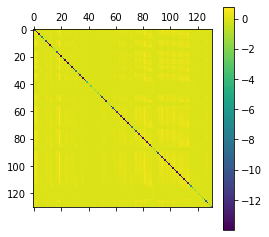

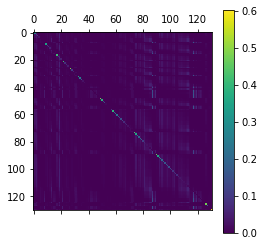

In [203]:
elasticities_blp= blp_results.compute_elasticities()
diversions_blp = blp_results.compute_diversion_ratios()
plt.colorbar(plt.matshow(elasticities_blp));
plt.colorbar(plt.matshow(diversions_blp));

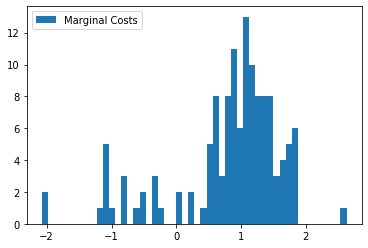

In [205]:
costs_blp = blp_results.compute_costs()
plt.hist(costs_blp, bins=50);
plt.legend(["Marginal Costs"]);

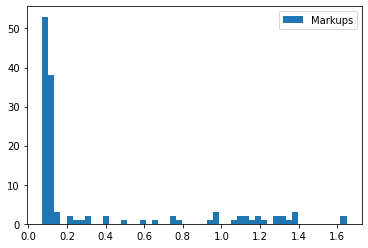

In [208]:
markups_blp = blp_results.compute_markups(costs=costs_blp)
plt.hist(markups_blp, bins=50);
plt.legend(["Markups"]);

### Question 8: Incorporate moments

In [247]:
np.sqrt(np.cov(dataset['power'], aweights=dataset['quantity']))

0.34169321984487205

In [255]:
moment_power_income= pyblp.DemographicInteractionMoment(1, 1, 0.7*45000*
                                                        np.sqrt(np.cov(dataset['power'], aweights=dataset['quantity'])), 1000)

In [260]:
initial_sigma = np.diag([0,0])
initial_pi = np.diag([-1e3, 0])
initial_beta = logit_demandonly.to_dict(['beta'])['beta']
blp_micro_results = problem.solve(
    initial_sigma,
    initial_pi,
    micro_moments= [moment_power_income],
    initial_update= True
)
blp_micro_results

Problem Results Summary:
GMM   Objective  Gradient            Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Hessian   Shares   Condition Number  Condition Number 
----  ---------  --------  --------  -------  ----------------  -----------------
 2    +1.1E+00   +8.1E-11  +4.0E-06     0         +2.3E+22          +8.0E+07     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:00:06       Yes          13           25          1953         5874    

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:   prices    power    |   Pi:    1*1/income   income 
------  --------  --------  |  ------  ----------  --------
prices  +0.0E+00            |  prices   +1.6E+04   +0.0E+00
                            |          (+4.2E+02)          
                 

In [258]:
W= blp_results.updated_W
W.shape
blp_results.W.shape

(12, 12)